### Importing GT

In [21]:
import json
import numpy as np
from scipy.spatial.transform import Rotation as R
from compas.geometry import oriented_bounding_box_numpy
from pytorch3d.ops import box3d_overlap
import torch
import os
import open3d as o3d

IOU_THRESHOLD = 0.1
LABEL_FOLDER = "labels/"

gt_jsons = [f for f in os.listdir(LABEL_FOLDER) if f.endswith('.json') and "gt" in f]
pred_jsons = [f for f in os.listdir(LABEL_FOLDER) if f.endswith('.json') and "pred" in f]
gt_jsons.sort(), pred_jsons.sort()
gt_jsons = gt_jsons[:3]
pred_jsons = pred_jsons[:3]
gt_jsons, pred_jsons

(['1_cropped_gt.json', '2_cropped_gt.json', '515_gt.json'],
 ['1_cropped_pred.json', '2_cropped_pred.json', '515_pred.json'])

In [22]:
def compute_3d_IoU(box1, box2):
    box1 = torch.tensor(box1, dtype=torch.float32).unsqueeze(0)
    box2 = torch.tensor(box2, dtype=torch.float32).unsqueeze(0)
    vol, IoU =  box3d_overlap(box1, box2)

    return IoU.item()

In [23]:
def reorder_vertices(box):
    """
    A unit cube, defined with the pythorch3d convention, has the following vertices:
        [0, 0, 0],                    (4) +---------+. (5)
        [1, 0, 0],                        | ` .     |  ` .
        [1, 1, 0],                        | (0) +---+-----+ (1)
        [0, 1, 0],                        |     |   |     |
        [0, 0, 1],                    (7) +-----+---+. (6)|
        [1, 0, 1],                        ` .   |     ` . |
        [1, 1, 1],                        (3) ` +---------+ (2)
        [0, 1, 1],
    
    While the OrientedBoundingBox from Open3D has the following vertices:
       [0, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 1, 1],
       [0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]

    This function reorders the vertices of the OrientedBoundingBox to match the pytorch3d convention.
    This allows to use the official IoU function from Pytorch3D.
    """
    assert box.shape == (8, 3)

    reordered = [
        box[0], box[1], box[7], box[2],
        box[3], box[6], box[4], box[5]
    ]
    return np.array(reordered)

In [24]:
def create_obb_from_description(centroid, dimensions, rotations):
    # Extract centroid, dimensions, and rotations
    cx, cy, cz = centroid["x"], centroid["y"], centroid["z"]
    length, width, height = dimensions["length"], dimensions["width"], dimensions["height"]
    rx, ry, rz = rotations["x"], rotations["y"], rotations["z"]

    # Create the 8 corners of the box before rotation and translation
    dx = length / 2
    dy = width / 2
    dz = height / 2

    corners = np.array([
        [-dx, -dy, -dz],
        [ dx, -dy, -dz],
        [ dx,  dy, -dz],
        [-dx,  dy, -dz],
        [-dx, -dy,  dz],
        [ dx, -dy,  dz],
        [ dx,  dy,  dz],
        [-dx,  dy,  dz]
    ])

    # Apply rotations
    rotation = R.from_euler('xyz', [rx, ry, rz], degrees=True)
    rotated_corners = rotation.apply(corners)

    # Apply translation (centroid)
    translated_corners = rotated_corners + np.array([cx, cy, cz])

    return translated_corners

In [25]:
class Obj:
    def __init__(self, label, bbox):
        assert isinstance(label, str)
        assert isinstance(bbox, o3d.geometry.OrientedBoundingBox)
        self.label = label
        self.bbox = reorder_vertices(np.asarray(bbox.get_box_points()))

class Gt_Obj(Obj):
    def __init__(self, label, bbox):
        super().__init__(label, bbox)
        self.points = None
        self.centroid = np.mean(bbox.get_box_points(), axis=0)
    def OBB(self):
        box = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(self.bbox))
        box.color = [0, 1, 0]
        return box

class Pred_Obj(Obj):
    def __init__(self, id, label, bbox, points, score):
        super().__init__(label, bbox)
        self.points = points
        self.centroid = np.mean(points, axis=0)
        self.id = id
        self.score = score
    def OBB(self):
        box = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(self.bbox))
        box.color = [1, 0, 0]
        return box


class ObjList:
    def __init__(self, objects: list):
        assert isinstance(objects, list)
        assert all(isinstance(obj, Obj) for obj in objects)
        self.objects = objects

    def __getitem__(self, key):
        return self.objects[key]

    def __len__(self):
        return len(self.objects)

    def get_boxes_list(self):
        return [obj.bbox for obj in self.objects]

In [26]:
def load_gt(gt_json):
    for obj in gt_json["objects"]:
        obj["bbox"] = create_obb_from_description(
            obj["centroid"], obj["dimensions"], obj["rotations"]
        ).tolist()
    gt_objects = []
    for obj in gt_json["objects"]:
        v = o3d.utility.Vector3dVector(obj["bbox"])
        bbox = o3d.geometry.OrientedBoundingBox.create_from_points(v)
        gt_objects.append(Gt_Obj(obj["name"], bbox))

    return ObjList(gt_objects)


def load_pred(pred_json):
    predicted_objects = pred_json["objects"]
    for obj in predicted_objects:
        obj["bbox"] = np.array(obj["OBB"]).reshape(8, 3)
        obj["points"] = np.array(obj["points"]).reshape(-1, 3)
        obj["minimum_bbox"] = oriented_bounding_box_numpy(obj["points"])

    # Load predicted bboxes
    pred_objects = []
    for obj in predicted_objects:
        bbox = np.array(obj["minimum_bbox"]).reshape(8, 3)
        v = o3d.utility.Vector3dVector(bbox)
        if np.sum(bbox) == 0:
            continue
        try:
            bbox = o3d.geometry.OrientedBoundingBox.create_from_points(v)
            pred_objects.append(Pred_Obj(obj["id"], obj["label"], bbox, obj["points"], obj["score"]))
        except:
            pass

    return ObjList(pred_objects)


def load_data(gt_jsons, pred_jsons):
    DATA = {}
    gt_jsons.sort(), pred_jsons.sort()


    for i, (gt_json, pred_json) in enumerate(zip(gt_jsons, pred_jsons)):
        pc_path = json.load(open(LABEL_FOLDER + gt_json))["path"]
        pointCloud = o3d.io.read_point_cloud("../labelCloud/" + pc_path)
        gt_objects = load_gt(json.load(open(LABEL_FOLDER + gt_json)))
        pred_objects = load_pred(json.load(open(LABEL_FOLDER + pred_json)))
        DATA[i] = {
            "pointcloud": pointCloud,
            "gt": gt_objects,
            "pred": pred_objects,
        }

    return DATA


DATA = load_data(gt_jsons, pred_jsons)

In [27]:
idx = 0
label2idx = {}
for scene in DATA:
    gt_objects = DATA[scene]["gt"].objects
    pred_objects = DATA[scene]["pred"].objects
    for obj in gt_objects:
        if obj.label not in label2idx:
            label2idx[obj.label] = idx
            idx += 1

    for obj in pred_objects:
        if obj.label not in label2idx:
            label2idx[obj.label] = idx
            idx += 1

id2label = {v: k for k, v in label2idx.items()}
label2idx, id2label

({'tv': 0,
  'backpack': 1,
  'handbag': 2,
  'chair': 3,
  'laptop': 4,
  'bottle': 5,
  'person': 6,
  'dining table': 7,
  'mouse': 8,
  'couch': 9,
  'keyboard': 10,
  'bowl': 11,
  'suitcase': 12,
  'cup': 13},
 {0: 'tv',
  1: 'backpack',
  2: 'handbag',
  3: 'chair',
  4: 'laptop',
  5: 'bottle',
  6: 'person',
  7: 'dining table',
  8: 'mouse',
  9: 'couch',
  10: 'keyboard',
  11: 'bowl',
  12: 'suitcase',
  13: 'cup'})

In [28]:
def custom_draw_geometry(pcd, gt_objects, pred_objects):
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pcd)

    for obj in gt_objects:
        vis.add_geometry(obj.OBB())

    for obj in pred_objects:
        vis.add_geometry(obj.OBB())

    vis.run()
    vis.destroy_window()

In [29]:
#custom_draw_geometry(*DATA[0].values())

In [30]:
import matplotlib.pyplot as plt


# Associating GT and predicted objects
def compute_3d_iou_matrix(gt_boxes, pred_boxes):
    """
    Compute the 3D IoU matrix between GT and predicted objects.

    Parameters:
    - gt_boxes: list of GT OrientedBoundingBox objects.
    - pred_boxes: list of predicted OrientedBoundingBox objects.

    Returns:
    - numpy array: 2D array where element (i, j) is the IoU between GT object i and predicted object j.
    """
    iou_matrix = np.zeros((len(gt_boxes), len(pred_boxes)))
    for i, gt_box in enumerate(gt_boxes):
        for j, pred_box in enumerate(pred_boxes):
            iou_matrix[i, j] = compute_3d_IoU(gt_box, pred_box)
    return iou_matrix


def get_matches(gt_objects, pred_objects, iou_threshold=0.5):
    """
    Get the matched GT and predicted objects.
    returns:
     - matched_couples: list of dictionaries containing the matched GT and predicted objects and their IoU.
     - phantom_predictions: list of predicted objects that have no match.
     - missed_gt: list of GT objects that have no match.
    """

    gt_boxes = gt_objects.get_boxes_list()
    pred_boxes = pred_objects.get_boxes_list()
    iou_matrix = compute_3d_iou_matrix(gt_boxes, pred_boxes)

    matches = []
    for i, j in zip(*np.where(iou_matrix > iou_threshold)):
        matches.append({"gt": i, "pred": j, "iou": iou_matrix[i, j]})
    matches = sorted(matches, key=lambda x: x["iou"], reverse=True)

    matched_gt = set()
    matched_preds = set()
    matched_couples = []
    for match in matches:
        if match["gt"] not in matched_gt and match["pred"] not in matched_preds:
            matched_gt.add(match["gt"])
            matched_preds.add(match["pred"])
            matched_couples.append(
                {
                    "gt": gt_objects[match["gt"]],
                    "pred": pred_objects[match["pred"]],
                    "iou": match["iou"],
                }
            )

    phantom_preds = [
        pred_objects[i] for i in range(len(pred_objects)) if i not in matched_preds
    ]
    missed_gt = [gt_objects[i] for i in range(len(gt_objects)) if i not in matched_gt]

    ious = [match["iou"] for match in matched_couples]
    assert len(ious) == len(set(ious))
    assert len(matched_couples) + len(phantom_preds) == len(pred_objects)
    assert len(matched_couples) + len(missed_gt) == len(gt_objects)

    return matched_couples, phantom_preds, missed_gt

matching_dict, phantom_preds_dict, missed_gt_dict = {}, {}, {}
for scene in DATA:
    gt_objects = DATA[scene]["gt"]
    pred_objects = DATA[scene]["pred"]
    matching_dict[scene], phantom_preds_dict[scene], missed_gt_dict[scene] = get_matches(gt_objects, pred_objects, IOU_THRESHOLD)

In [31]:
#scene = 1
#print("GT objects that have no match: ", len(missed_gt_dict[scene]))
#print("Predicted objects that have no match: ", len(phantom_preds_dict[scene]))
#custom_draw_geometry(DATA[scene]["pointcloud"], missed_gt_dict[scene], phantom_preds_dict[scene])

In [32]:
matching, phantom_preds, missed_gt = [], [], []
for scene in DATA:
    matching.extend(matching_dict[scene])
    phantom_preds.extend(phantom_preds_dict[scene])
    missed_gt.extend(missed_gt_dict[scene])

In [33]:
def compute_confusion_matrix(matches, phantom_preds, missed_gt, label2idx, score_threshold=0.5):
    num_classes = len(label2idx)
    conf_matrix = np.zeros((num_classes + 1, num_classes + 1), dtype=np.int32)
    
    for match in matches:
        gt_idx = label2idx[match['gt'].label]
        pred_idx = label2idx[match['pred'].label]
        score = match['pred'].score

        if score >= score_threshold:
            conf_matrix[gt_idx, pred_idx] += 1
        else:
            conf_matrix[gt_idx, num_classes] += 1  # FN
            conf_matrix[num_classes, pred_idx] += 1  # FP
    
    for missed in missed_gt:
        gt_idx = label2idx[missed.label]
        conf_matrix[gt_idx, num_classes] += 1
    
    for phantom in phantom_preds:
        pred_idx = label2idx[phantom.label]
        conf_matrix[num_classes, pred_idx] += 1

    return conf_matrix

conf_matrix = compute_confusion_matrix(matching, phantom_preds, missed_gt, label2idx, 0.9)
conf_matrix

array([[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6],
       [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [8, 3, 1, 7, 3, 4, 0, 4, 3, 2, 7, 1, 1, 1, 0]], dtype=int32)

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_metrics_from_confusion_matrix(conf_matrix, num_classes):
    y_true = []
    y_pred = []
    
    for i in range(num_classes + 1):
        for j in range(num_classes + 1):
            y_true.extend([i] * conf_matrix[i, j])
            y_pred.extend([j] * conf_matrix[i, j])
    
    precision = precision_score(y_true, y_pred, average=None, labels=range(num_classes + 1), zero_division=1)
    recall = recall_score(y_true, y_pred, average=None, labels=range(num_classes + 1), zero_division=1)
    f1 = f1_score(y_true, y_pred, average=None, labels=range(num_classes + 1), zero_division=1)
    accuracy = accuracy_score(y_true, y_pred, normalize=True)
    
    return precision[:-1], recall[:-1], f1[:-1], accuracy

precision, recall, f1, accuracy = compute_metrics_from_confusion_matrix(conf_matrix, len(label2idx))
precision, recall, f1, accuracy

(array([0.27272727, 0.        , 0.5       , 0.3       , 0.5       ,
        0.        , 1.        , 0.        , 0.        , 0.33333333,
        0.        , 0.        , 0.        , 0.        ]),
 array([0.375     , 0.        , 0.5       , 0.33333333, 0.75      ,
        0.        , 1.        , 0.        , 0.        , 0.5       ,
        0.        , 1.        , 1.        , 1.        ]),
 array([0.31578947, 0.        , 0.5       , 0.31578947, 0.6       ,
        0.        , 1.        , 0.        , 0.        , 0.4       ,
        0.        , 0.        , 0.        , 0.        ]),
 0.1411764705882353)

In [42]:
from sklearn.metrics import average_precision_score

def MAP(matching, phantom_preds, missed_gt, label2idx):
    n_samples = len(matching) + len(phantom_preds) + len(missed_gt)
    num_classes = len(label2idx)
    Y_true = np.zeros((n_samples, num_classes + 1), dtype=bool)
    Y_pred = np.zeros((n_samples, num_classes + 1), dtype=np.float32)

    print(n_samples, len(matching), len(phantom_preds), len(missed_gt))

    for i, match in enumerate(matching):
        gt_idx = label2idx[match['gt'].label]
        pred_idx = label2idx[match['pred'].label]
        score = match['pred'].score

        Y_true[i, gt_idx] = True
        Y_pred[i, pred_idx] = score
    
    for i, missed in enumerate(missed_gt):
        gt_idx = label2idx[missed.label]
        Y_true[i + len(matching), gt_idx] = True
        Y_pred[i + len(matching), num_classes] = 0.0
    
    for i, phantom in enumerate(phantom_preds):
        pred_idx = label2idx[phantom.label]
        Y_pred[i + len(matching) + len(missed_gt), pred_idx] = phantom.score
        Y_true[i + len(matching) + len(missed_gt), num_classes] = True 
    
    print(np.sum(Y_true, axis = 0))
    
    MAP = average_precision_score(Y_true, Y_pred, average='weighted')
    return MAP

MAP(matching, phantom_preds, missed_gt, label2idx)

67 30 27 10
[ 8  2  2  9  4  2  1  6  2  2  2  0  0  0 27]


/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


0.5673417737184724

(100, 15)


<Axes: xlabel='Recall', ylabel='Precision'>

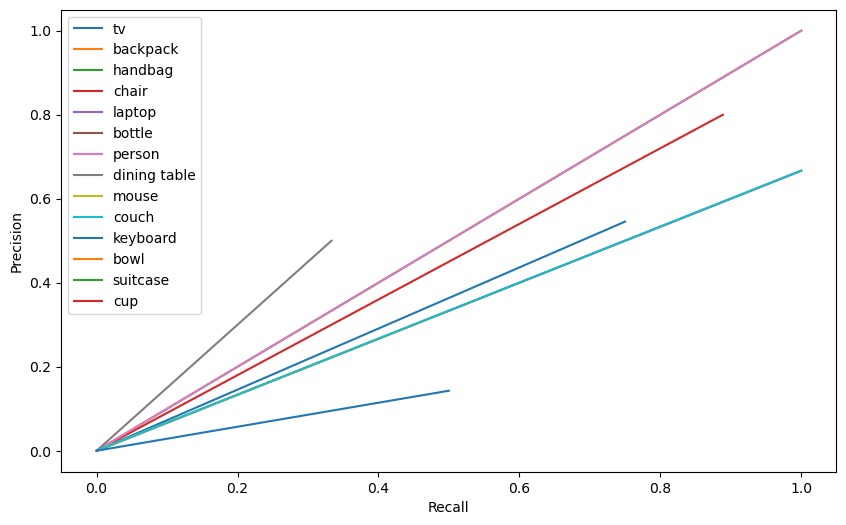

In [36]:
def AP(matching, phantom_preds, missed_gt, label2idx, return_ax_plot=False):
    precisions, recalls, f1s, accuracies = [], [], [], []

    for thr in np.linspace(0, 1, 100):
        conf_matrix = compute_confusion_matrix(matching, phantom_preds, missed_gt, label2idx, score_threshold=thr)
        precision, recall, f1, accuracy = compute_metrics_from_confusion_matrix(conf_matrix, len(label2idx))
        precision = np.append(precision, 1)
        recall = np.append(recall, 0)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        accuracies.append(accuracy)
    
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1s = np.array(f1s)
    accuracies = np.array(accuracies)

    print(precisions.shape)
    ap = []
    for i in range(precisions.shape[1] -1):
        prec = precisions[:, i]
        rec = recalls[:, i]
        ap.append(np.sum((rec[:-1] - rec[1:]) * prec[:-1]))

    
    if return_ax_plot:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        for i in range(len(label2idx)):
            ax.plot(recalls[:, i], precisions[:, i], label=id2label[i])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend()

        return ap, ax

    return ap, None


ap, ax = AP(matching, phantom_preds, missed_gt, label2idx, True)

ax

In [37]:
ap = np.array(ap)

In [38]:
np.mean(ap[ap != 0]), np.mean(ap), ap

(0.4243650793650794,
 0.30311791383219955,
 array([0.25      , 0.5       , 0.75      , 0.42222222, 0.45833333,
        0.        , 1.        , 0.125     , 0.16666667, 0.5       ,
        0.07142857, 0.        , 0.        , 0.        ]))

In [39]:
under_represented = np.argwhere(ap == 0).flatten()
for id in under_represented:
    print(f"{id2label[id]} is under-represented.")

bottle is under-represented.
bowl is under-represented.
suitcase is under-represented.
cup is under-represented.
